In [1]:
import os
import sys
import networkx as nx
import numpy as np
from epynet import Network

sys.path.insert(0, os.path.join('..'))
from utils.graph_utils import get_nx_graph, get_sensitivity_matrix
from utils.SensorInstaller import SensorInstaller
from utils.DataReader import DataReader

In [2]:
wds_id = 'anytown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

### Loading WDS topology

In [4]:
wds = Network(path_to_wds)
G = get_nx_graph(wds, mode='weighted')
installer = SensorInstaller(wds)

In [5]:
coords = {}
for node in wds.nodes:
    arr = [node.coordinates[0], node.coordinates[1]]
    coords[int(node.index)] = arr

In [6]:
node_colors = ['#ffffff' for _ in G.nodes]
# nx.draw(G, pos=coords, with_labels=True, node_color=node_colors)

### Collecting master nodes

In [7]:
master_nodes = installer.master_nodes

### Calculating sensitivity matrix

In [8]:
pert = np.max(wds.junctions.basedemand)/100
S = get_sensitivity_matrix(wds, pert)

### Shortest path selection

In [9]:
sensor_budget = 5
# installer.deploy_by_random(sensor_budget=sensor_budget, seed=1)
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by=None)
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by='length')
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by='iweight')
# installer.deploy_by_shortest_path_with_sensitivity(
#     sensor_budget = sensor_budget,
#     sensitivity_matrix = S,
#     weight_by = 'iweight'
# )
installer.deploy_by_shortest_path_with_sensitivity_rnd(
    sensor_budget = sensor_budget,
    sensitivity_matrix = S,
    weight_by = 'iweight'
)

sensor_nodes = installer.sensor_nodes

### Sensor placement plot

In [10]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
    except:
        print(node)
for node in sensor_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'

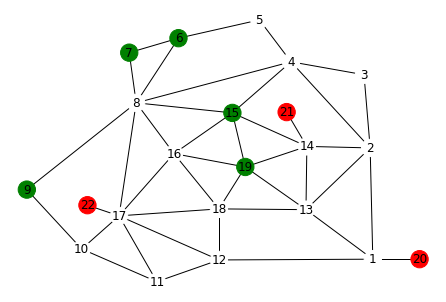

In [11]:
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors, alpha=None)

### Sensitivity matrix

In [12]:
sensitive_nodes = set((np.argsort(np.sum(np.abs(S), axis=0))+1)[::-1][:sensor_budget])

In [13]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
    except:
        print(node)
for node in sensitive_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'

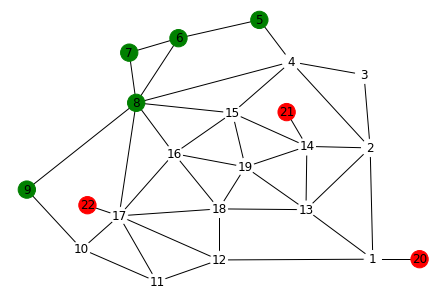

In [14]:
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors, alpha=None)

In [15]:
list(wds.junctions)[0].index

1